In [26]:
# The number of entries to read in. Use it to have fast turn-around
max_events = None
# Number on CV folds
n_cv = 5

import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)

import time
import gc
import copy

import mlflow
import mlflow.sklearn
from mlflow.entities import SourceType


import keggler as kg

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

PATH = '/home/mlisovyi/.kaggle/competitions/santander-customer-transaction-prediction/'

print(os.listdir(PATH))

['train.csv', 'sample_submission.csv', 'test.csv']


In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
df_trn = pd.read_csv(PATH+'train.csv')
df_tst = pd.read_csv(PATH+'test.csv')

In [29]:
df_trn = kg.reduce_mem_usage(df_trn, force_obj_in_category=False)
df_tst = kg.reduce_mem_usage(df_tst, force_obj_in_category=False)

Memory usage of dataframe is 319.76 MB
Memory usage after optimization is: 89.54 MB
Decreased by 72.0%
Memory usage of dataframe is 318.04 MB
Memory usage after optimization is: 89.16 MB
Decreased by 72.0%


In [30]:
df_trn.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,2.925781,3.181641,14.015625,0.574707,8.796875,14.570312,5.750000,-7.238281,4.285156,30.718750,10.531250,16.218750,2.578125,2.470703,14.382812,13.429688,-5.148438,-0.407227,4.929688,5.996094,-0.308594,12.906250,-3.876953,16.890625,11.195312,10.578125,0.676270,7.886719,4.667969,3.875000,-5.238281,7.375000,11.578125,12.046875,11.640625,-7.015625,5.921875,-14.210938,16.031250,5.324219,12.921875,29.046875,-0.693848,5.171875,-0.747559,14.835938,11.265625,5.382812,2.017578,10.117188,16.187500,4.960938,2.076172,-0.215454,8.671875,9.531250,5.804688,22.437500,5.011719,-4.699219,21.640625,0.566406,5.199219,8.859375,43.125000,18.375000,-2.343750,23.406250,6.519531,12.195312,13.648438,13.835938,1.367188,2.941406,-4.519531,21.468750,9.320312,16.453125,8.000000,-1.707031,-21.453125,6.781250,11.093750,9.992188,14.843750,0.181152,8.960938,16.25000,2.173828,-3.414062,9.476562,13.312500,26.531250,1.440430,14.710938,6.046875,9.539062,17.156250,14.109375,24.359375,2.033203,6.761719,3.914062,-0.485107,2.523438,1.509766,2.550781,15.578125,-13.421875,7.273438,16.015625,9.726562,0.889648,0.775391,4.222656,12.000000,13.859375,-0.733887,-1.924805,15.445312,12.828125,0.358643,9.648438,6.566406,5.171875,3.134766,29.453125,31.406250,2.828125,15.656250,8.328125,-5.601562,19.062500,11.265625,8.695312,8.367188,11.562500,-16.468750,4.027344,17.921875,18.515625,10.781250,9.007812,16.703125,10.484375,1.657227,12.171875,-13.132812,17.609375,11.539062,15.460938,5.312500,3.615234,5.039062,6.675781,12.664062,2.701172,-0.697266,9.601562,5.488281,-4.765625,-8.421875,20.875000,3.152344,18.562500,7.742188,-10.125000,13.726562,-3.519531,1.719727,-8.406250,9.015625,3.066406,14.367188,25.843750,5.875000,11.843750,-19.718750,17.578125,0.585938,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,-0.403320,8.054688,14.023438,8.414062,5.433594,13.703125,13.828125,-15.585938,7.800781,28.578125,3.427734,2.740234,8.554688,3.371094,6.976562,13.890625,-11.765625,-2.558594,5.046875,0.548340,-9.296875,7.875000,1.286133,19.375000,11.367188,0.739746,2.798828,5.843750,10.812500,3.677734,-11.117188,1.873047,9.875000,11.781250,1.244141,-47.375000,7.371094,0.194824,34.406250,25.703125,11.835938,13.226562,-4.109375,6.687500,-8.093750,18.593750,19.328125,7.011719

# FE

In [31]:
from sklearn.neighbors import KNeighborsClassifier

def apply_fe(df, ss=None, mm=None, knn_dict={}):
    cols = [c for c in df.columns if 'var_' in c]
    df_out = df.copy(deep=True)
    if ss:
        df_ss = ss.transform(df[cols])        
#         if not knn_dict:
#             for i in [50]:
#                 t = time.time()
#                 knn_dict[i] = KNeighborsClassifier(i, n_jobs=4).fit(df_ss, df['target'])
#                 print('Trained KNN{} in {:.2f} sec'.format(i, time.time()-t))
#         for name,knn in knn_dict.items():
#             t = time.time()
#             df_out['knn_{}'.format(name)] = knn.predict_proba(df_ss)[:,1]
#             print('Applied KNN{} in {:.2f} sec'.format(name, time.time()-t))
#         for i in range(1,5):
#             df_out['n_sigma{}'.format(i)] = (df_ss >= i).sum(axis=1)
#         df_out['sum_sigmas'] = df_ss.sum(axis=1)
        del df_ss
        
#     if mm:
#         df_mm = mm.transform(df[cols])
#         df_out['sum_mm'] = df_mm.sum(axis=1)        
#         del df_mm
    
    return df_out, knn_dict

In [32]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
ss = StandardScaler().fit(df_trn.iloc[:,2:])
mm = MinMaxScaler().fit(df_trn.iloc[:,2:])

df_trn, knn = apply_fe(df_trn.iloc[:,:], ss=ss, mm=mm, knn_dict={})
df_tst, _ = apply_fe(df_tst, ss=ss, mm=mm, knn_dict=knn)

In [33]:
df_trn.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,2.925781,3.181641,14.015625,0.574707,8.796875,14.570312,5.750000,-7.238281,4.285156,30.718750,10.531250,16.218750,2.578125,2.470703,14.382812,13.429688,-5.148438,-0.407227,4.929688,5.996094,-0.308594,12.906250,-3.876953,16.890625,11.195312,10.578125,0.676270,7.886719,4.667969,3.875000,-5.238281,7.375000,11.578125,12.046875,11.640625,-7.015625,5.921875,-14.210938,16.031250,5.324219,12.921875,29.046875,-0.693848,5.171875,-0.747559,14.835938,11.265625,5.382812,2.017578,10.117188,16.187500,4.960938,2.076172,-0.215454,8.671875,9.531250,5.804688,22.437500,5.011719,-4.699219,21.640625,0.566406,5.199219,8.859375,43.125000,18.375000,-2.343750,23.406250,6.519531,12.195312,13.648438,13.835938,1.367188,2.941406,-4.519531,21.468750,9.320312,16.453125,8.000000,-1.707031,-21.453125,6.781250,11.093750,9.992188,14.843750,0.181152,8.960938,16.25000,2.173828,-3.414062,9.476562,13.312500,26.531250,1.440430,14.710938,6.046875,9.539062,17.156250,14.109375,24.359375,2.033203,6.761719,3.914062,-0.485107,2.523438,1.509766,2.550781,15.578125,-13.421875,7.273438,16.015625,9.726562,0.889648,0.775391,4.222656,12.000000,13.859375,-0.733887,-1.924805,15.445312,12.828125,0.358643,9.648438,6.566406,5.171875,3.134766,29.453125,31.406250,2.828125,15.656250,8.328125,-5.601562,19.062500,11.265625,8.695312,8.367188,11.562500,-16.468750,4.027344,17.921875,18.515625,10.781250,9.007812,16.703125,10.484375,1.657227,12.171875,-13.132812,17.609375,11.539062,15.460938,5.312500,3.615234,5.039062,6.675781,12.664062,2.701172,-0.697266,9.601562,5.488281,-4.765625,-8.421875,20.875000,3.152344,18.562500,7.742188,-10.125000,13.726562,-3.519531,1.719727,-8.406250,9.015625,3.066406,14.367188,25.843750,5.875000,11.843750,-19.718750,17.578125,0.585938,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,-0.403320,8.054688,14.023438,8.414062,5.433594,13.703125,13.828125,-15.585938,7.800781,28.578125,3.427734,2.740234,8.554688,3.371094,6.976562,13.890625,-11.765625,-2.558594,5.046875,0.548340,-9.296875,7.875000,1.286133,19.375000,11.367188,0.739746,2.798828,5.843750,10.812500,3.677734,-11.117188,1.873047,9.875000,11.781250,1.244141,-47.375000,7.371094,0.194824,34.406250,25.703125,11.835938,13.226562,-4.109375,6.687500,-8.093750,18.593750,19.328125,7.011719

# Training

In [34]:
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.base import clone, ClassifierMixin, RegressorMixin
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import time


def train_single_model(clf_, X_, y_, random_state_=314, opt_parameters_={}, fit_params_={}):
    '''
    A wrapper to train a model with particular parameters
    '''
    c = clone(clf_)
    c.set_params(**opt_parameters_)
    c.set_params(random_state=random_state_)
    return c.fit(X_, y_, **fit_params_)

def train_model_in_CV(model, X, y, metric, metric_args={},
                            model_name='xmodel',
                            seed=31416, n=5,
                            opt_parameters_={}, fit_params_={},
                            verbose=True,
                            groups=None, y_eval=None,
                            mlf=None, mlf_metric_name=None
                     ):
    # the list of classifiers for voting ensable
    clfs = []
    # performance 
    perf_eval = {'score_i_oof': 0,
                 'score_i_ave': 0,
                 'score_i_std': 0,
                 'score_i': [],
                 'fit_time': []
                }
    # full-sample oof prediction
    y_full_oof = pd.Series(np.zeros(shape=(y.shape[0],)), 
                          index=y.index)
    
    sample_weight=None
    if 'sample_weight' in metric_args:
        sample_weight=metric_args['sample_weight']
        
    index_weight=None
    if 'index_weight' in metric_args:
        index_weight=metric_args['index_weight']
        del metric_args['index_weight']
        
    doSqrt=False
    if 'sqrt' in metric_args:
        doSqrt=True
        del metric_args['sqrt']

    if groups is None:
        cv = StratifiedKFold(n, shuffle=True, random_state=seed) #Stratified
    else:
        cv = GroupKFold(n)
    # The out-of-fold (oof) prediction for the k-1 sample in the outer CV loop
    y_oof = pd.Series(np.zeros(shape=(X.shape[0],)), 
                      index=X.index)
    scores = []
    clfs = []
    feature_importances = []

    for n_fold, (trn_idx, val_idx) in enumerate(cv.split(X, (y!=0).astype(np.int8), groups=groups)):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if 'LGBMRanker' in type(model).__name__ and groups is not None:
            G_trn, G_val = groups.iloc[trn_idx], groups.iloc[val_idx]        

        if fit_params_:
            # use _stp data for early stopping
            fit_params_["eval_set"] = [(X_trn,y_trn), (X_val,y_val)]
            fit_params_['verbose'] = verbose
            if index_weight is not None:
                fit_params_["sample_weight"] = y_trn.index.map(index_weight).values
                fit_params_["eval_sample_weight"] = [None, y_val.index.map(index_weight).values]
            if 'LGBMRanker' in type(model).__name__ and groups is not None:
                fit_params_['group'] = G_trn.groupby(G_trn, sort=False).count()
                fit_params_['eval_group'] = [G_trn.groupby(G_trn, sort=False).count(),
                                             G_val.groupby(G_val, sort=False).count()]

        #display(y_trn.head())
        t = time.time()
        clf = train_single_model(model, X_trn, y_trn, 314+n_fold, opt_parameters_, fit_params_)
        perf_eval['fit_time'].append(time.time()-t)

        clfs.append(('{}{}'.format(model_name,n_fold), clf))
        # oof predictions
        if isinstance(clf, RegressorMixin):
            y_oof.iloc[val_idx] = clf.predict(X_val)
        elif isinstance(clf, ClassifierMixin):
            y_oof.iloc[val_idx] = clf.predict_proba(X_val)[:,1]
        else:
            y_oof.iloc[val_idx] = clf.predict(X_val)
        # prepare weights for evaluation
        if sample_weight is not None:
            metric_args['sample_weight'] = y_val.map(sample_weight)
        elif index_weight is not None:
            metric_args['sample_weight'] = y_val.index.map(index_weight).values
        # prepare target values
        y_true_tmp = y_val if 'LGBMRanker' not in type(model).__name__  and y_eval is None else y_eval.iloc[val_idx]
        y_pred_tmp = y_oof.iloc[val_idx] if y_eval is None else y_oof.iloc[val_idx]        
        #store evaluated metric
        metric_value = metric(y_true_tmp, y_pred_tmp, **metric_args)
        scores.append(metric_value)
        if mlf is not None:
            mlf.log_metric("{}_Fold{}".format(mlf_metric_name, n_fold), metric_value)
        #
        fi_tmp = pd.DataFrame()
        fi_tmp["feature"] = X.columns
        if hasattr(clf, 'feature_importances_'):
            fi_tmp["importance"] = clf.feature_importances_
        fi_tmp["fold"] = n_fold + 1
        feature_importances.append(fi_tmp)
        #cleanup
        del X_trn, y_trn, X_val, y_val, y_true_tmp, y_pred_tmp

    # Store performance info for this CV
    if sample_weight is not None:
        metric_args['sample_weight'] = y_oof.map(sample_weight)
    elif index_weight is not None:
        metric_args['sample_weight'] = y_oof.index.map(index_weight).values
    perf_eval['score_i_oof'] = metric(y, y_oof, **metric_args)
    perf_eval['score_i'] = scores
    
    if doSqrt:
        for k in perf_eval.keys():
            if 'score' in k:
                perf_eval[k] = np.sqrt(perf_eval[k])
        scores = np.sqrt(scores)
            
    perf_eval['score_i_ave'] = np.mean(scores)
    perf_eval['score_i_std'] = np.std(scores)

    return clfs, perf_eval, y_oof, pd.concat(feature_importances, axis=0)

def print_perf_clf(name, perf_eval):
    print('Performance of the model:')    
    print('Mean(Val) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      perf_eval['score_i_ave'],
                                                                      perf_eval['score_i_std']
                                                                     ))
    print('Min/max scores on folds: {:.4f} / {:.4f}'.format(np.min(perf_eval['score_i']),
                                                            np.max(perf_eval['score_i'])))
    print('OOF score inner {} Classifier: {:.4f}'.format(name, perf_eval['score_i_oof']))
    print('Scores in individual folds: {}'.format(['{:.4f}'.format(x) for x in perf_eval['score_i']]))

In [35]:
def learning_rate_decay_power(current_iter):
    '''
    The function defines learning rate deay for LGBM
    '''
    base_learning_rate = 1e-1
    min_lr = 1e-2
    lr = base_learning_rate  * np.power(.95, current_iter)
    return lr if lr > min_lr else min_lr

def learning_rate_steps_5k(current_iter):
    '''
    The function defines learning rate deay for LGBM
    '''
    period = 5000
    return 1e-2 / (1 + current_iter//period)

learning_rate_decay_power(1000)

0.01

In [40]:
mdl_inputs = {
    'lgbm_base': (
        lgb.LGBMClassifier(
            max_depth=-1,
            min_child_samples=40,
            random_state=314,
            silent=True,
            metric='None',
            n_jobs=4,
            n_estimators=25000,
            importance_type='gain'),
        {
            'colsample_bytree': 0.02,
            'subsample': 0.05,
            'min_child_weight': 100.0,
            'min_child_samples': 100,
            'learning_rate': 0.005,
            'num_leaves': 25,
#             'class_weight': 'balanced'
        },
#         {
#             'colsample_bytree': 0.05,
#             'subsample': 0.05,
#             'min_child_weight': 100.0,
#             'min_child_samples': 100,
#             'learning_rate': 0.01,
#             'num_leaves': 15,
# #             'scale_pos_weight': 0.3,
# #             'reg_alpha': 0,
# #             'reg_lambda': 50,
# #             'class_weight': 'balanced'
#         },
        {
            "early_stopping_rounds": 1000,
            "eval_metric": 'auc',
#             'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_steps_5k)],
#             'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
        },
        df_trn['target'],
        None),
#         'lgbm_rf': (lgb.LGBMClassifier(boosting_type='rf', reg_lambda=0, #min_child_samples=400, 
#                          max_depth=-1, random_state=314, silent=True, metric='None', 
#                          n_jobs=4, bagging_freq=1, importance_type='gain'),
#                {'colsample_bytree': 0.05, 'min_child_samples': 300, 'min_child_weight': 100, 
#                   'num_leaves': 100, 'subsample': 0.2, 'n_estimators':1500,}, 
#                {},
#                df_trn['target'],
#             None),
}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test = {
    'num_leaves': [7, 15, 25, 70],#sp_randint(6, 100),
#     'min_child_samples': [100,300,500,700,900],#sp_randint(100, 1000),
    'min_child_weight': [10,100],#[1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': [0.1, 0.15, 0.2, 0.4],#sp_uniform(loc=0.5, scale=0.5),
    'colsample_bytree': [0.02,0.05,0.1],#[0.35,0.50,0.65,0.75,0.85,0.95],#sp_uniform(loc=0.5, scale=0.5),
#     'reg_alpha': [0, 1e-1],
#     'reg_lambda': [0, 1e-3, 1e-1, 1]
}

from sklearn.model_selection import ParameterSampler, ParameterGrid
par_sampler = ParameterSampler(param_test, n_iter=20, random_state=31416)

par_grid = ParameterGrid([#{'colsample_bytree':[0.035,0.065]},
                          #{'subsample': [0.1, 0.15, 0.25, 0.3, 0.4]}
                          {'n_estimators': [4000, 8000]}
                         ])

features_not2use = ['ID_code', 'target']

In [37]:
# for v in ['var_89', 'var_139', 'var_12', 'var_81']:
#     kg.plot_var_for2classes(df_trn, v, bins=50,
#                             target_name='target')
#     plt.title(v)

--------------- lgbm_base -----------
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.893961	valid_1's auc: 0.874072
[4000]	training's auc: 0.917147	valid_1's auc: 0.88836
[6000]	training's auc: 0.929889	valid_1's auc: 0.894898
[8000]	training's auc: 0.93826	valid_1's auc: 0.89824
[10000]	training's auc: 0.944614	valid_1's auc: 0.899907
[12000]	training's auc: 0.950071	valid_1's auc: 0.900662
[14000]	training's auc: 0.95505	valid_1's auc: 0.901063
[16000]	training's auc: 0.959597	valid_1's auc: 0.90119
[18000]	training's auc: 0.963753	valid_1's auc: 0.90127
[20000]	training's auc: 0.967584	valid_1's auc: 0.901323
[22000]	training's auc: 0.971056	valid_1's auc: 0.90134
Early stopping, best iteration is:
[21270]	training's auc: 0.969818	valid_1's auc: 0.901365
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.894929	valid_1's auc: 0.871847
[4000]	training's auc: 0.91747	valid_1's auc: 0.886087
[6000]	training

[4000]	training's auc: 0.924302	valid_1's auc: 0.899641
[6000]	training's auc: 0.928858	valid_1's auc: 0.900782
[8000]	training's auc: 0.932629	valid_1's auc: 0.90147
[10000]	training's auc: 0.936327	valid_1's auc: 0.902043
[12000]	training's auc: 0.939906	valid_1's auc: 0.902248
Early stopping, best iteration is:
[12999]	training's auc: 0.94161	valid_1's auc: 0.902325
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.920042	valid_1's auc: 0.892761
[4000]	training's auc: 0.925583	valid_1's auc: 0.895761
[6000]	training's auc: 0.929864	valid_1's auc: 0.896958
[8000]	training's auc: 0.933635	valid_1's auc: 0.897647
[10000]	training's auc: 0.93721	valid_1's auc: 0.897939
[12000]	training's auc: 0.940705	valid_1's auc: 0.898209
Early stopping, best iteration is:
[11810]	training's auc: 0.940389	valid_1's auc: 0.898241
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.918621	valid_1's auc: 0.893424
[4000]	training

Early stopping, best iteration is:
[9814]	training's auc: 0.995963	valid_1's auc: 0.902425
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.960985	valid_1's auc: 0.88963
[4000]	training's auc: 0.975043	valid_1's auc: 0.892281
[6000]	training's auc: 0.985409	valid_1's auc: 0.893573
[8000]	training's auc: 0.992252	valid_1's auc: 0.894124
[10000]	training's auc: 0.996342	valid_1's auc: 0.894285
Early stopping, best iteration is:
[10039]	training's auc: 0.996399	valid_1's auc: 0.894316
Performance of the model:
Mean(Val) score inner lgbm_base Classifier: 0.8994+-0.0029
Min/max scores on folds: 0.8943 / 0.9024
OOF score inner lgbm_base Classifier: 0.8992
Scores in individual folds: ['0.9017', '0.8985', '0.9000', '0.9024', '0.8943']
The list of features with 0 importance: 
[]
--------------- lgbm_base -----------
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.918627	valid_1's auc: 0.893038
[4000]	training's auc

The list of features with 0 importance: 
[]
--------------- lgbm_base -----------
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.933215	valid_1's auc: 0.899314
[4000]	training's auc: 0.940131	valid_1's auc: 0.901287
[6000]	training's auc: 0.945928	valid_1's auc: 0.901865
[8000]	training's auc: 0.950916	valid_1's auc: 0.902216
[10000]	training's auc: 0.955784	valid_1's auc: 0.902424
Early stopping, best iteration is:
[9699]	training's auc: 0.955088	valid_1's auc: 0.902471
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.934502	valid_1's auc: 0.894585
[4000]	training's auc: 0.941169	valid_1's auc: 0.897125
[6000]	training's auc: 0.946683	valid_1's auc: 0.898033
[8000]	training's auc: 0.9517	valid_1's auc: 0.898384
[10000]	training's auc: 0.956476	valid_1's auc: 0.898483
Early stopping, best iteration is:
[9540]	training's auc: 0.955429	valid_1's auc: 0.898523
Training until validation scores don't improve f

The list of features with 0 importance: 
[]
--------------- lgbm_base -----------
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.90397	valid_1's auc: 0.887419
[4000]	training's auc: 0.91493	valid_1's auc: 0.892771
[6000]	training's auc: 0.923501	valid_1's auc: 0.896425
[8000]	training's auc: 0.930203	valid_1's auc: 0.898849
[10000]	training's auc: 0.935503	valid_1's auc: 0.900372
[12000]	training's auc: 0.939937	valid_1's auc: 0.901246
[14000]	training's auc: 0.943869	valid_1's auc: 0.90177
[16000]	training's auc: 0.947399	valid_1's auc: 0.902033
[18000]	training's auc: 0.950693	valid_1's auc: 0.902075
Early stopping, best iteration is:
[17786]	training's auc: 0.950353	valid_1's auc: 0.902103
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.904838	valid_1's auc: 0.884318
[4000]	training's auc: 0.915827	valid_1's auc: 0.89026
[6000]	training's auc: 0.924339	valid_1's auc: 0.89405
[8000]	training's auc: 0.9

[10000]	training's auc: 0.959553	valid_1's auc: 0.897942
[12000]	training's auc: 0.965879	valid_1's auc: 0.898153
[14000]	training's auc: 0.97135	valid_1's auc: 0.898193
Early stopping, best iteration is:
[13548]	training's auc: 0.970186	valid_1's auc: 0.898251
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.920297	valid_1's auc: 0.886553
[4000]	training's auc: 0.933437	valid_1's auc: 0.892716
[6000]	training's auc: 0.943549	valid_1's auc: 0.896032
[8000]	training's auc: 0.95192	valid_1's auc: 0.898079
[10000]	training's auc: 0.959126	valid_1's auc: 0.899214
[12000]	training's auc: 0.9654	valid_1's auc: 0.899791
[14000]	training's auc: 0.97092	valid_1's auc: 0.900022
[16000]	training's auc: 0.975646	valid_1's auc: 0.900089
[18000]	training's auc: 0.979673	valid_1's auc: 0.900173
Early stopping, best iteration is:
[17540]	training's auc: 0.9788	valid_1's auc: 0.900203
Training until validation scores don't improve for 1000 rounds.
[2000]	training

[16000]	training's auc: 0.921653	valid_1's auc: 0.898628
[18000]	training's auc: 0.923585	valid_1's auc: 0.899133
[20000]	training's auc: 0.925377	valid_1's auc: 0.899528
[22000]	training's auc: 0.927144	valid_1's auc: 0.899829
[24000]	training's auc: 0.928867	valid_1's auc: 0.900017
Did not meet early stopping. Best iteration is:
[25000]	training's auc: 0.929731	valid_1's auc: 0.90008
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.90001	valid_1's auc: 0.889434
[4000]	training's auc: 0.905397	valid_1's auc: 0.89345
[6000]	training's auc: 0.90919	valid_1's auc: 0.89628
[8000]	training's auc: 0.912012	valid_1's auc: 0.897949
[10000]	training's auc: 0.914623	valid_1's auc: 0.899264
[12000]	training's auc: 0.916877	valid_1's auc: 0.900113
[14000]	training's auc: 0.91907	valid_1's auc: 0.90085
[16000]	training's auc: 0.921055	valid_1's auc: 0.901292
[18000]	training's auc: 0.92296	valid_1's auc: 0.901709
[20000]	training's auc: 0.924811	valid_1's au

[4000]	training's auc: 0.933437	valid_1's auc: 0.892716
[6000]	training's auc: 0.943549	valid_1's auc: 0.896032
[8000]	training's auc: 0.95192	valid_1's auc: 0.898079
[10000]	training's auc: 0.959126	valid_1's auc: 0.899214
[12000]	training's auc: 0.9654	valid_1's auc: 0.899791
[14000]	training's auc: 0.97092	valid_1's auc: 0.900022
[16000]	training's auc: 0.975646	valid_1's auc: 0.900089
[18000]	training's auc: 0.979673	valid_1's auc: 0.900173
Early stopping, best iteration is:
[17540]	training's auc: 0.9788	valid_1's auc: 0.900203
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.920173	valid_1's auc: 0.890783
[4000]	training's auc: 0.933034	valid_1's auc: 0.896736
[6000]	training's auc: 0.943054	valid_1's auc: 0.899581
[8000]	training's auc: 0.951667	valid_1's auc: 0.901151
[10000]	training's auc: 0.958924	valid_1's auc: 0.901957
[12000]	training's auc: 0.9653	valid_1's auc: 0.902481
[14000]	training's auc: 0.970912	valid_1's auc: 0.902675
[160

[12000]	training's auc: 0.924582	valid_1's auc: 0.889491
[14000]	training's auc: 0.927657	valid_1's auc: 0.891037
[16000]	training's auc: 0.93019	valid_1's auc: 0.89213
[18000]	training's auc: 0.932415	valid_1's auc: 0.892891
[20000]	training's auc: 0.934418	valid_1's auc: 0.893399
[22000]	training's auc: 0.936302	valid_1's auc: 0.893704
[24000]	training's auc: 0.938068	valid_1's auc: 0.893936
Did not meet early stopping. Best iteration is:
[25000]	training's auc: 0.938919	valid_1's auc: 0.89402
Performance of the model:
Mean(Val) score inner lgbm_base Classifier: 0.8990+-0.0030
Min/max scores on folds: 0.8940 / 0.9021
OOF score inner lgbm_base Classifier: 0.8990
Scores in individual folds: ['0.9016', '0.8974', '0.8997', '0.9021', '0.8940']
The list of features with 0 importance: 
[]


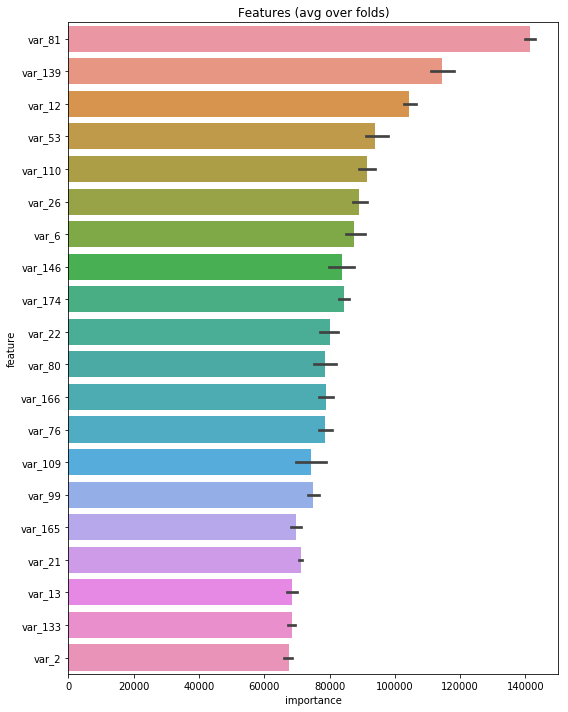

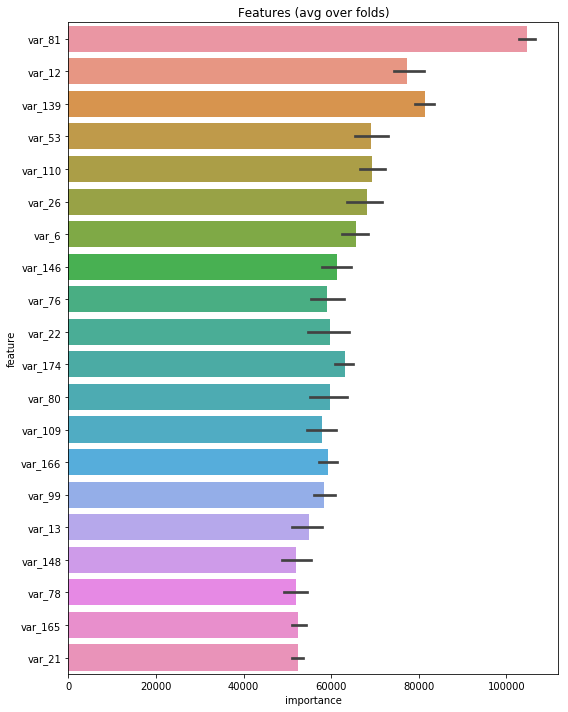

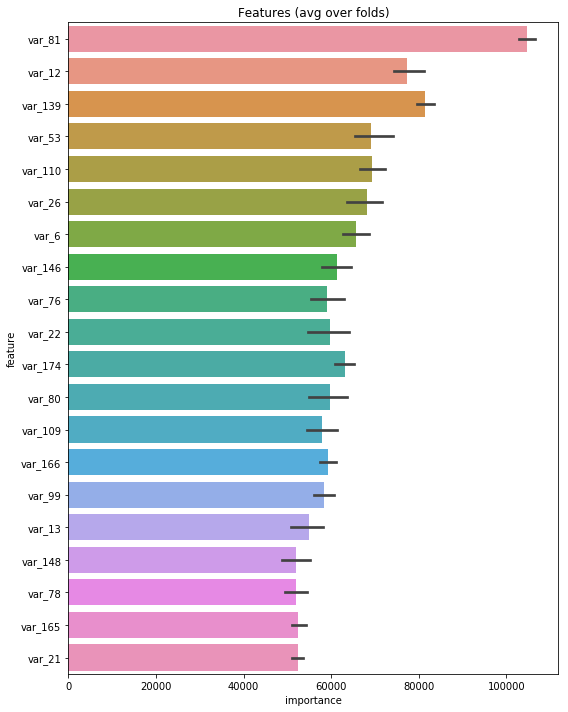

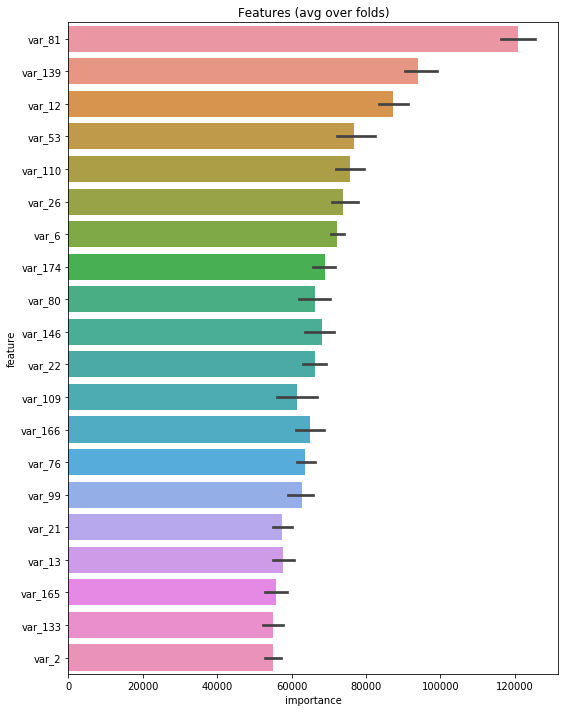

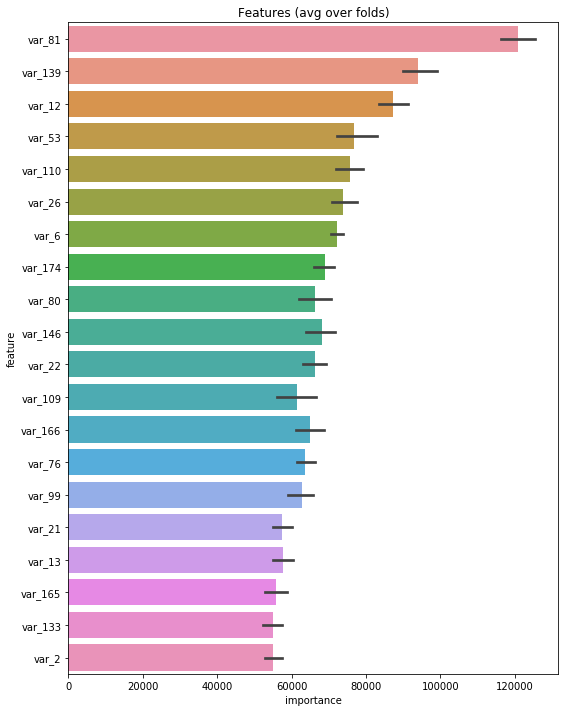

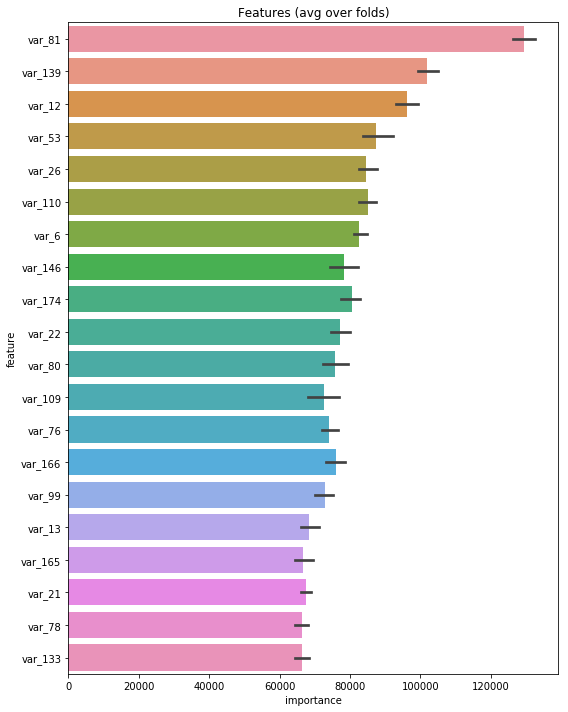

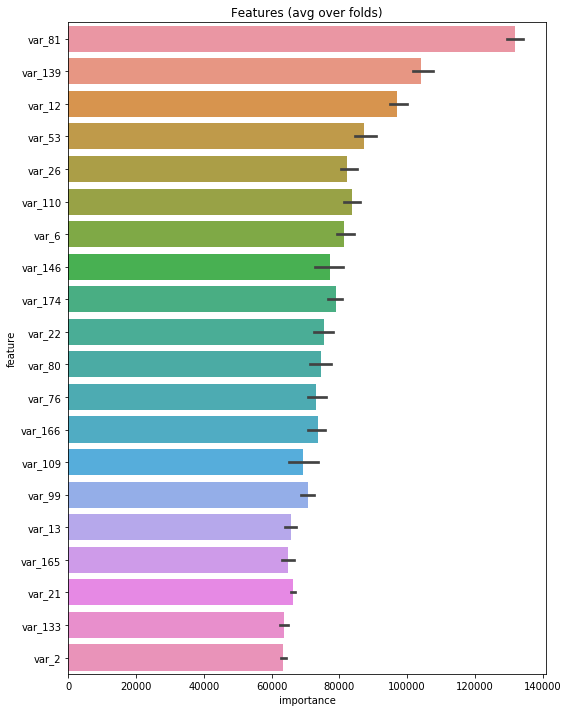

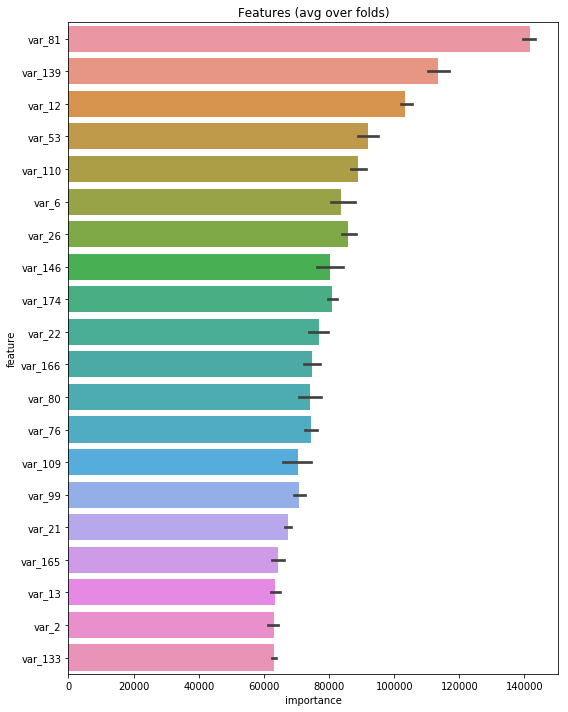

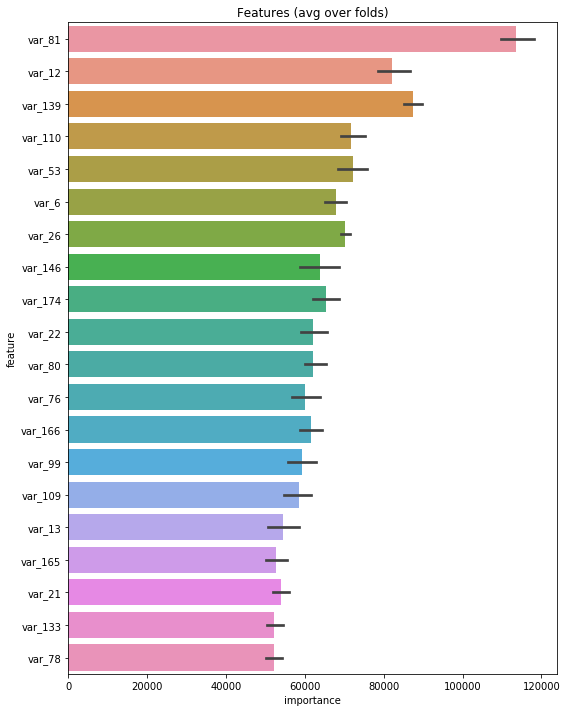

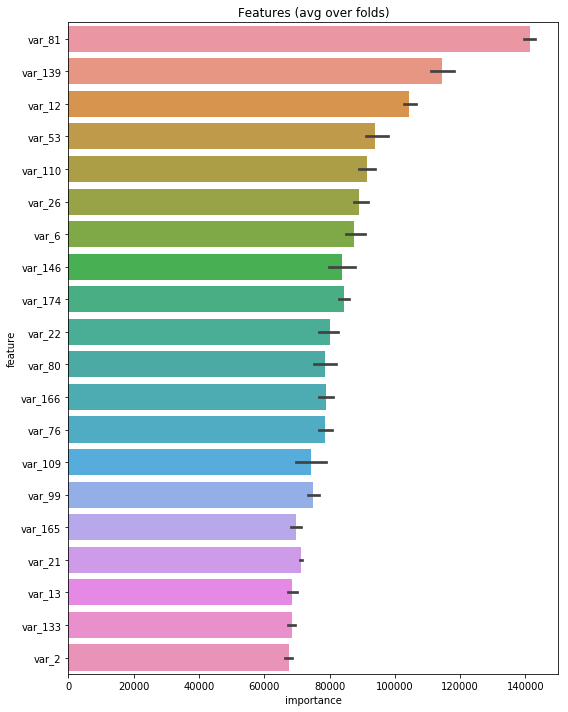

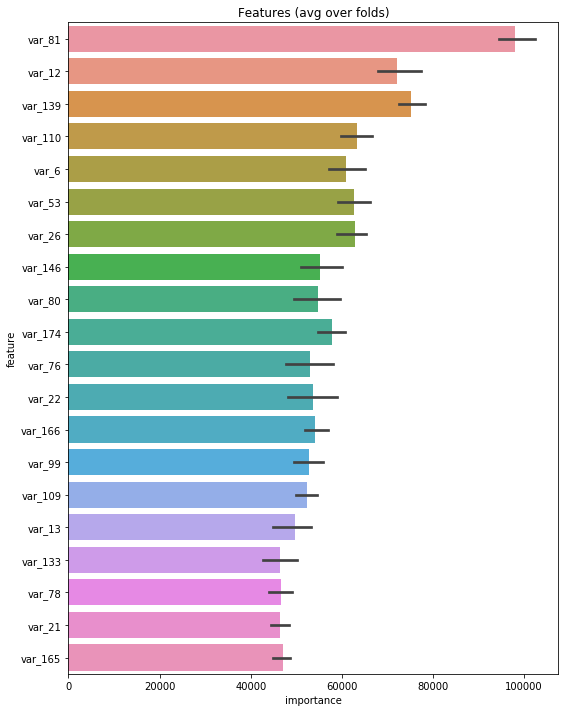

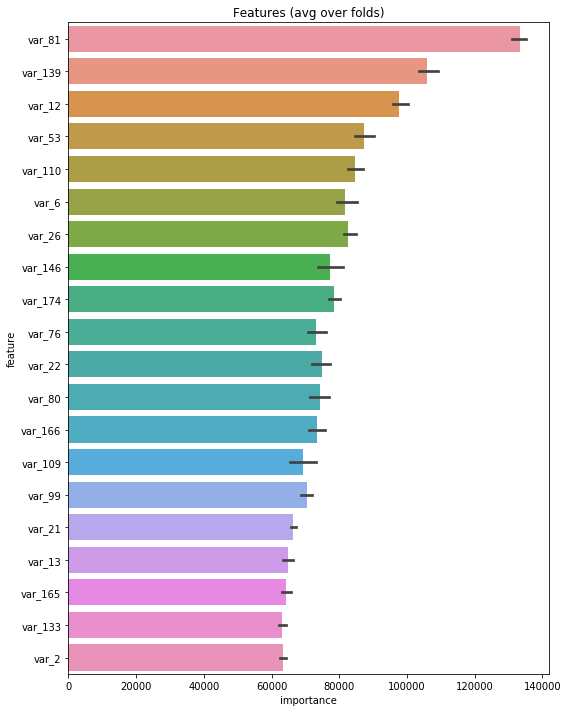

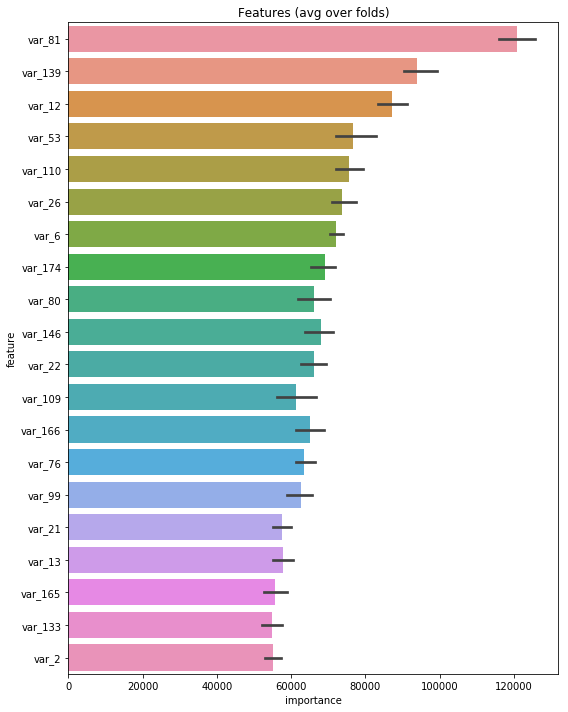

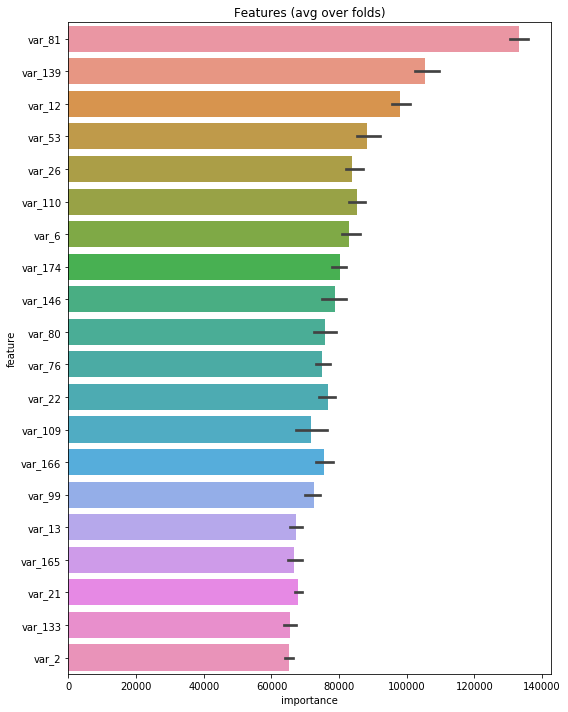

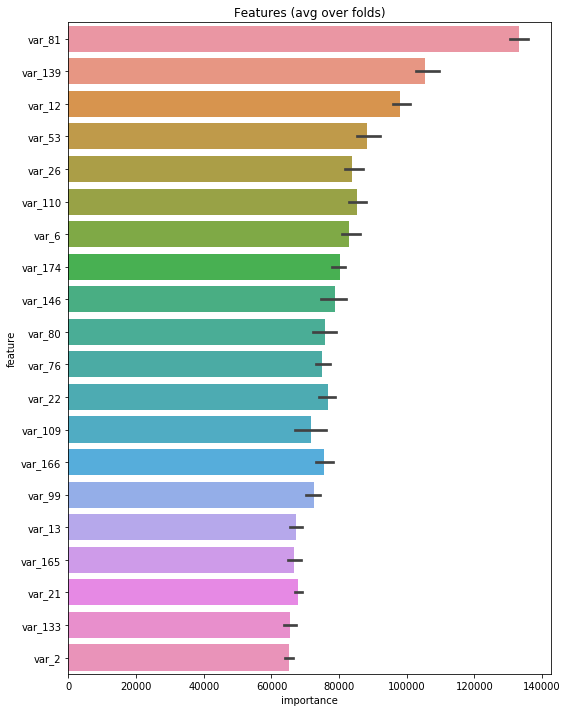

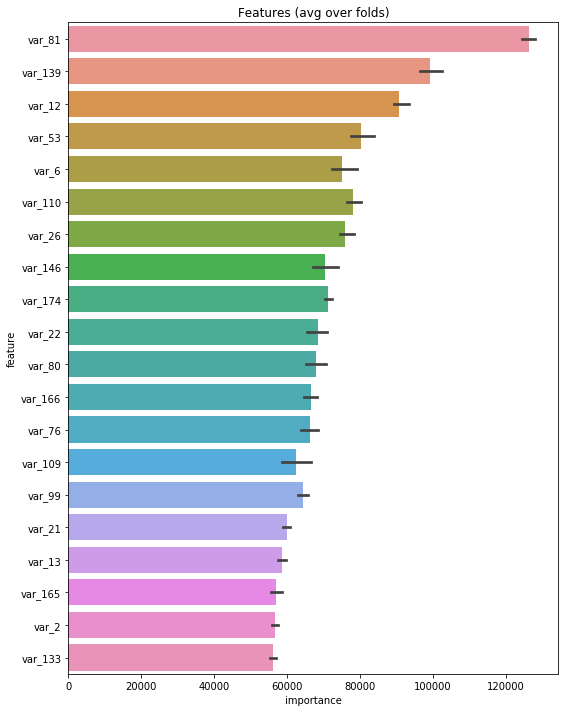

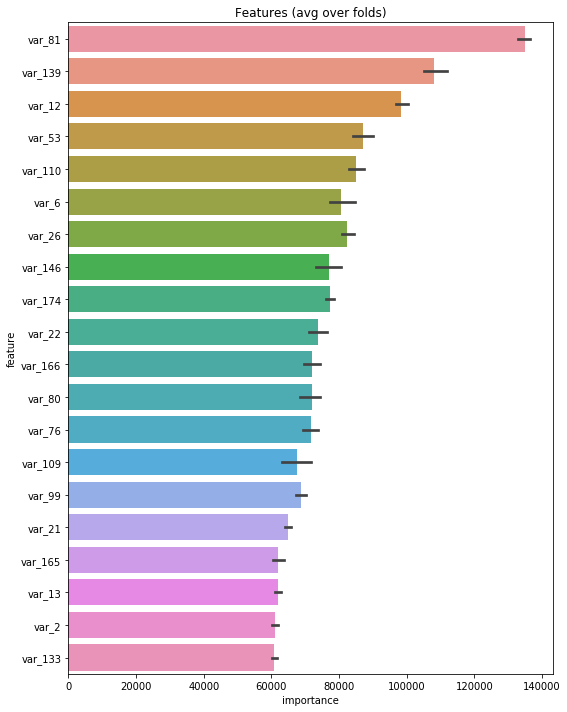

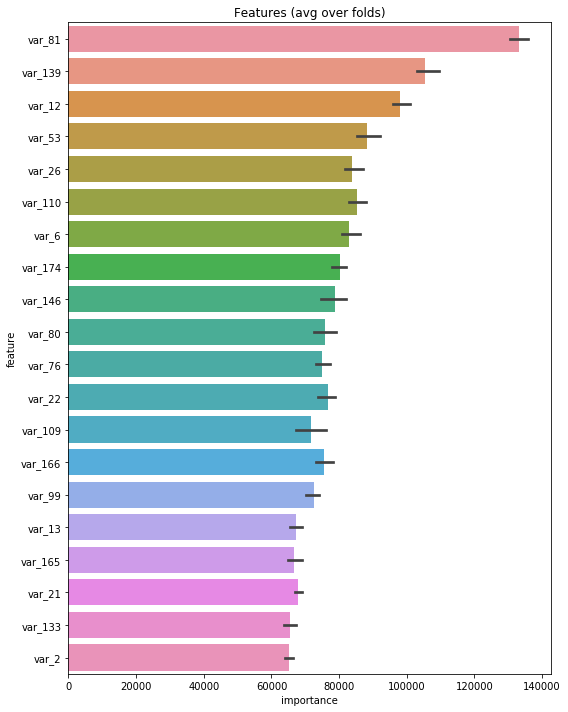

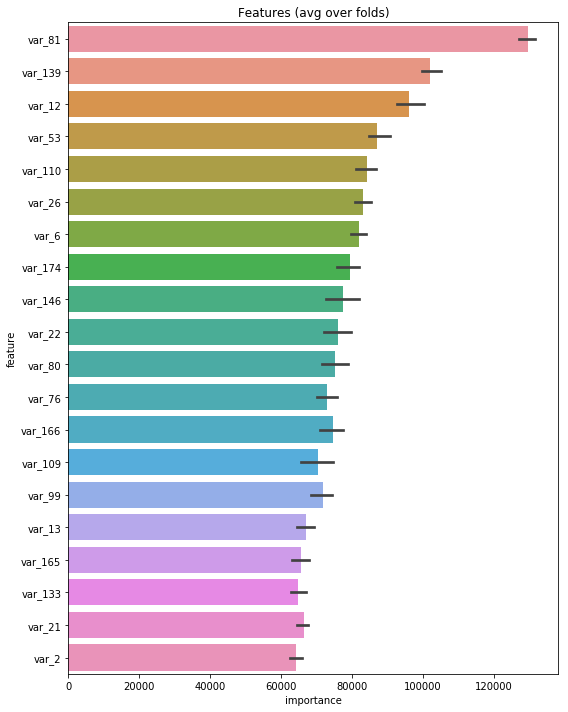

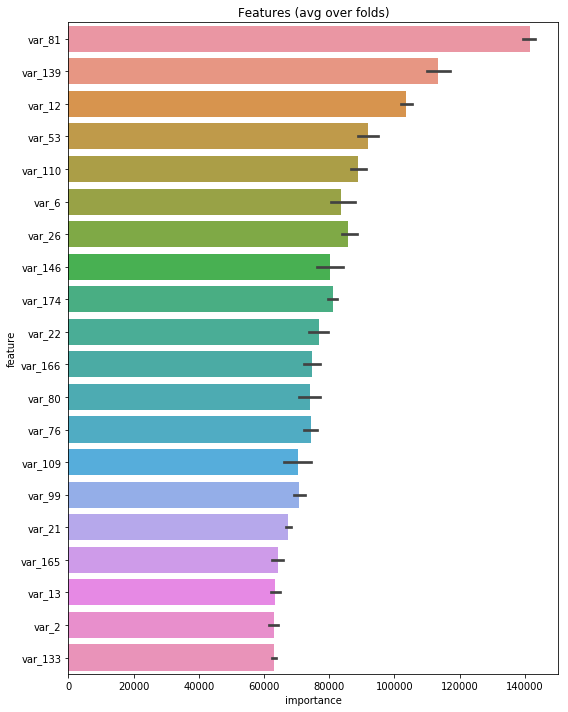

In [41]:
feats = [c for c in df_trn.columns if c not in features_not2use]

n_trn = None
seed_cv = 31416

mdls = {}
results = {}
y_oofs = {}
fis = {}  # feature importances

mlflow.set_experiment('HP_RS_Stratified')

for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    for ps in par_sampler: # par_sampler
        mdl_pars_ = copy.deepcopy(mdl_pars)
        mdl_pars_.update(ps)
        with mlflow.start_run(source_type=SourceType.NOTEBOOK, source_version=kg.get_last_git_commit()):
            print('--------------- {} -----------'.format(name))
            mlflow.set_tag('model_name', name)
            # Logging
            for k, v in mdl_pars_.items():
                mlflow.log_param(k, v)
            if n_trn is not None:
                mlflow.log_param('n_trn', n_trn)
            mlflow.log_param('seed_cv', seed_cv)

            mdl_, perf_eval_, y_oof_, fi_ = train_model_in_CV(
                mdl,
                df_trn[feats].iloc[:n_trn, :],
                y_.iloc[:n_trn],
                roc_auc_score,
                metric_args={},
                model_name=name,
                opt_parameters_=mdl_pars_,
                fit_params_=fit_pars,
                n=n_cv,
                seed=seed_cv,
                verbose=2000, groups=g_,
                mlf=mlflow, mlf_metric_name='AUC'
            )
            results[name] = perf_eval_
            mdls[name] = mdl_
            y_oofs[name] = y_oof_
            fis[name] = fi_
            print_perf_clf(name, perf_eval_)

            # metrics
            mlflow.log_metric("AUC", perf_eval_['score_i_ave'])
            mlflow.log_metric("AUC_STD", perf_eval_['score_i_std'])
#             for i in range(n_cv):
#                 m = mdls['lgbm_base'][i][1]
#                 for j in range(m.best_iteration_):
#                     mlflow.log_metric("AUC_Fold{}".format(i), m.evals_result_['valid_1']['auc'][j])
            fit_time_ave = np.mean(perf_eval_['fit_time'])
            if hasattr(mdl_[0][1],'n_estimators'):
                n_trees_ave = np.nanmean([m[1].n_estimators for m in mdl_])
            if getattr(mdl_[0][1], 'best_iteration_', None) is not None:
                n_trees_ave = np.nanmean([m[1].best_iteration_ for m in mdl_])    
            mlflow.log_metric('Time_sec', fit_time_ave)
            mlflow.log_metric('N_trees', n_trees_ave)
            mlflow.log_metric('Time_per_tree_msec', fit_time_ave / n_trees_ave * 1000)
            # artifacts
            # OOF
            y_oof_.to_csv('out/oof.csv', index=False)
            mlflow.log_artifact(os.getcwd()+'/out/oof.csv')
            # Submission
            sub = pd.DataFrame(index=df_tst['ID_code'])
            sub['target'] = 0
            for n, m in mdl_:
                sub['target'] += m.predict_proba(df_tst[feats])[:,1]/n_cv
            sub.to_csv('out/sub.csv', index=False)
            mlflow.log_artifact(os.getcwd()+'/out/sub.csv')
            #
            for v in fis:
                kg.display_importances(fis[v], n_feat=20, fout_name='out/fi.png')
                mlflow.log_artifact(os.getcwd()+'/out/fi.png')

In [12]:
feats = [c for c in df_trn.columns if c not in features_not2use]

n_trn = None#-100000
n_ho = None
seed_cv = 31416

mdls = {}
results = {}
y_oofs = {}
fis = {}  # feature importances

mlflow.set_experiment('TMP')

for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    mdl_pars_ = copy.deepcopy(mdl_pars)
    with mlflow.start_run():
        print('--------------- {} -----------'.format(name))
        mlflow.set_tag('model_name', name)
        # Logging
        for k, v in mdl_pars_.items():
            mlflow.log_param(k, v)
        if n_trn is not None:
            mlflow.log_param('n_trn', n_trn)
        mlflow.log_param('seed_cv', seed_cv)

        mdl_, perf_eval_, y_oof_, fi_ = train_model_in_CV(mdl,
            df_trn[feats].iloc[:n_trn, :], y_.iloc[:n_trn],
            roc_auc_score,
            metric_args={},
            model_name=name,
            opt_parameters_=mdl_pars_,
            fit_params_=fit_pars,
            n=n_cv, seed=seed_cv,
            verbose=500, groups=g_,
            mlf=mlflow, mlf_metric_name='AUC')
        results[name] = perf_eval_
        mdls[name] = mdl_
        y_oofs[name] = y_oof_
        fis[name] = fi_
        print_perf_clf(name, perf_eval_)

        # metrics
        mlflow.log_metric("AUC", perf_eval_['score_i_ave'])
        mlflow.log_metric("AUC_STD", perf_eval_['score_i_std'])
#             for i in range(n_cv):
#                 m = mdls['lgbm_base'][i][1]
#                 for j in range(m.best_iteration_):
#                     mlflow.log_metric("AUC_Fold{}".format(i), m.evals_result_['valid_1']['auc'][j])
        fit_time_ave = np.mean(perf_eval_['fit_time'])
        if hasattr(mdl_[0][1],'n_estimators'):
            n_trees_ave = np.nanmean([m[1].n_estimators for m in mdl_])
        if getattr(mdl_[0][1], 'best_iteration_', None) is not None:
            n_trees_ave = np.nanmean([m[1].best_iteration_ for m in mdl_])
        mlflow.log_metric('Time_sec', fit_time_ave)
        mlflow.log_metric('N_trees', n_trees_ave)
        mlflow.log_metric('Time_per_tree_sec', fit_time_ave / n_trees_ave * 1000)
#         # artifacts
#         # OOF
#         y_oof_.to_csv('out/oof.csv', index=False)
#         mlflow.log_artifact(os.getcwd()+'/out/oof.csv')
#         # Submission
#         sub = pd.DataFrame(index=df_tst['ID_code'])
#         sub['target'] = 0
#         for n, m in mdl_:
#             sub['target'] += m.predict_proba(df_tst[feats])[:,1]/n_cv
#         sub.to_csv('out/sub.csv', index=False)
#         mlflow.log_artifact(os.getcwd()+'/out/sub.csv')
#         #
#         kg.display_importances(fis['lgbm_base'], n_feat=20, fout_name='out/fi.png')
#         mlflow.log_artifact(os.getcwd()+'/out/fi.png')

INFO: 'TMP' does not exist. Creating a new experiment
--------------- lgbm_base -----------
Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.92161	valid_1's auc: 0.888815
[1000]	training's auc: 0.93007	valid_1's auc: 0.895934
[1500]	training's auc: 0.932932	valid_1's auc: 0.897777
[2000]	training's auc: 0.935916	valid_1's auc: 0.899526
[2500]	training's auc: 0.937688	valid_1's auc: 0.899743
[3000]	training's auc: 0.939549	valid_1's auc: 0.900233
[3500]	training's auc: 0.941316	valid_1's auc: 0.900952
[4000]	training's auc: 0.942876	valid_1's auc: 0.901141
[4500]	training's auc: 0.944394	valid_1's auc: 0.901218
[5000]	training's auc: 0.945911	valid_1's auc: 0.901327
[5500]	training's auc: 0.947326	valid_1's auc: 0.901442
[6000]	training's auc: 0.948758	valid_1's auc: 0.901642
[6500]	training's auc: 0.950109	valid_1's auc: 0.901683
[7000]	training's auc: 0.951296	valid_1's auc: 0.901746
[7500]	training's auc: 0.952611	valid_1's auc: 0.901895
[8000]	

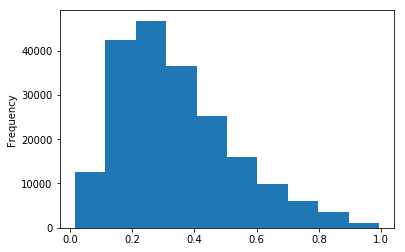

In [15]:
y_oofs['lgbm_base'].plot.hist()

In [17]:
oof_0 = y_oofs['lgbm_base'][df_trn['target']==0]
oof_1 = y_oofs['lgbm_base'][df_trn['target']==1]

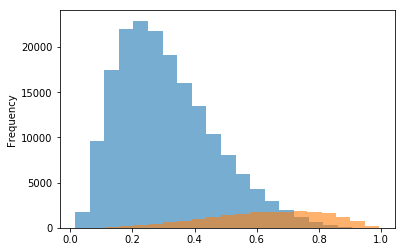

In [23]:
oof_0.plot.hist(bins=20, alpha=0.6)
oof_1.plot.hist(bins=20, alpha=0.6)

In [24]:
oof_0.nlargest(10)

155311    0.954520
58770     0.948073
91983     0.945380
103419    0.943824
57788     0.940490
107285    0.939453
53859     0.936201
89831     0.935183
121471    0.929572
157407    0.929488
dtype: float64

In [25]:
df_trn.loc[oof_0.nlargest(10).index]

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
155311,train_155311,0,9.945312,1.412109,13.820312,9.421875,12.171875,0.285400,5.914062,16.531250,1.370117,7.785156,2.457031,-7.617188,13.796875,13.789062,10.257812,14.390625,8.679688,-11.679688,32.531250,15.304688,21.890625,19.968750,1.582031,3.740234,11.484375,13.468750,11.281250,0.428711,6.089844,8.593750,-4.343750,10.953125,0.011398,14.710938,11.351562,8.859375,2.666016,7.449219,17.875000,6.488281,10.429688,15.625000,11.609375,11.250000,9.437500,6.683594,10.968750,-2.816406,28.421875,26.296875,12.515625,17.687500,-4.703125,5.792969,-5.226562,20.500000,12.937500,6.125000,6.945312,9.507812,18.328125,-5.316406,1.613281,-5.378906,9.171875,2.447266,5.832031,18.609375,5.019531,1.979492,46.187500,0.750977,1.272461,17.843750,-1.658203,16.125000,4.585938,22.000000,6.800781,14.203125,13.226562,12.976562,-2.283203,10.328125,-5.324219,16.437500,16.140625,14.539062,7.027344,4.160156,-3.964844,6.863281,7.054688,10.742188,10.648438,0.287109,19.765625,27.921875,1.697266,2.232422,0.854980,19.703125,23.078125,1.546875,10.343750,3.886719,12.406250,20.250000,14.070312,7.179688,2.107422,6.433594,2.751953,6.003906,2.802734,0.056213,1.958008,14.117188,-1.936523,10.703125,21.453125,7.531250,8.429688,7.734375,3.316406,12.093750,13.859375,-2.574219,-3.058594,14.062500,12.968750,0.672852,8.609375,7.214844,-2.761719,2.611328,15.117188,31.140625,5.261719,-2.224609,7.757812,6.425781,6.539062,12.468750,8.179688,8.976562,8.750000,8.601562,4.035156,4.203125,19.109375,9.062500,9.492188,17.015625,-2.316406,9.812500,11.945312,0.744141,9.664062,6.632812,14.820312,5.675781,5.890625,11.562500,-0.493164,16.781250,3.007812,6.101562,3.820312,5.957031,0.275879,-10.937500,10.195312,3.642578,21.703125,11.093750,-10.898438,11.960938,-7.105469,8.343750,-12.898438,11.960938,-4.953125,6.117188,4.035156,-4.265625,8.226562,-9.445312,10.414062,-1.238281,1.797852,10.789062,5.726562,-4.125000,13.679688,0.209717,-3.544922,10.562500,8.468750,-11.648438
58770,train_58770,0,5.292969,-1.794922,12.859375,10.507812,12.687500,1.355469,7.109375,11.976562,0.651855,4.863281,-5.625000,0.003300,13.906250,9.382812,7.117188,14.750000,9.257812,-11.882812,32.500000,23.734375,11.531250,5.480469,4.968750,3.199219,5.234375,13.171875,-10.351562,-4.117188,5.410156,2.556641,-9.882812,9.523438,5.015625,5.062500,11.539062,2.605469,0.068115,4.875000,10.726562,3.636719,-19.031250,13.984375,12.218750,11.125000,8.859375,-37.687500,14.695312,-9.835938,39.000000,23.593750,12.757812,16.546875,5.292969,5.304688,-6.050781,4.359375,13

In [19]:
oof_0.shape

(179902,)

In [20]:
oof_1.shape

(20098,)

In [138]:
if n_ho is not None:
    n = 100000

    y_pred_prob = np.zeros((n, ))
    y_pred_bina = np.zeros((n, ))
    y_pred_rank = np.zeros((n, ))
    for i in range(n_cv):
        probs = mdls['lgbm_base'][i][1].predict_proba(df_trn[feats].iloc[-n:, :])[:,1]
        y_pred_prob += probs / n_cv
        y_pred_bina += (probs>0.05) / n_cv
        y_pred_rank += pd.Series(probs).rank(pct=True) / n_cv

    print(roc_auc_score(df_trn['target'].iloc[-n:], y_pred_prob))
    print(roc_auc_score(df_trn['target'].iloc[-n:], y_pred_bina))
    print(roc_auc_score(df_trn['target'].iloc[-n:], y_pred_rank))

0.8938534851282306
0.8605638532652267
0.8941656891461136


# Importances

## SHAP

In [12]:
import shap
shap.initjs()

In [13]:
n_shap=1000
explainer = shap.TreeExplainer(mdls['lgbm_base'][0][1])
shap_values = explainer.shap_values(df_trn[feats].iloc[:n_shap,:])

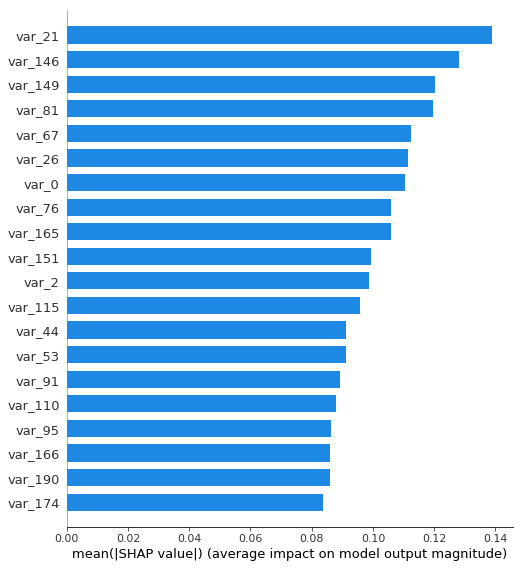

In [14]:
shap.summary_plot(shap_values, df_trn[feats].iloc[:n_shap,:], plot_type="bar")